In [27]:
import numpy as np
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

In [15]:
from sklearn import datasets  # MNIST 손글씨 데이터셋을 사용하기 위해 import 한다.
from sklearn.neighbors import KNeighborsClassifier  # kNN
from sklearn.svm import SVC  # SVM
from sklearn import tree  # 의사결정 트리
from sklearn.ensemble import VotingClassifier  # 하드/소프트 보팅을 계산하기 위해 import 한다.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

손글씨 데이터를 불러온다.

In [16]:
mnist = datasets.load_digits()  # MNIST 손글씨 데이터를 불러온다.
features, labels = mnist.data, mnist.target
features.shape, labels.shape

((1797, 64), (1797,))

학습 데이터와 테스트 데이터를 나눈다.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
print(f'학습 데이터 개수: {X_train.shape[0]}, 테스트 데이터 개수: {X_test.shape[0]}')

학습 데이터 개수: 1437, 테스트 데이터 개수: 360


단일 모델의 정확도 측정
앙상블 정확도를 측정하기에 앞서 kNN, SVM, 의사결정 트리 분류기를 만들어 단일 모델들의 정확도를 계산한다.

In [18]:
# kNN
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predict = knn.predict(X_test)
print(f'kNN accuracy: {accuracy_score(y_test, knn_predict):.2%}')

kNN accuracy: 84.72%


In [19]:
# SVM
svm = SVC(C=0.1, gamma=0.003, probability=True, random_state=35).fit(X_train, y_train)
svm_predict = svm.predict(X_test)
print(f'SVM accuracy: {accuracy_score(y_test, svm_predict):.2%}')

SVM accuracy: 89.17%


In [20]:
# 의사결정 트리
dtree = tree.DecisionTreeClassifier(max_depth=8, random_state=35).fit(X_train, y_train)
dtree_predict = dtree.predict(X_test)
print(f'DecisionTree accuracy: {accuracy_score(y_test, dtree_predict):.2%}')

DecisionTree accuracy: 83.61%


확률 합계

In [21]:
knn_proba = knn.predict_proba(X_test)
print(len(knn_proba))
print(knn_proba[0])
total = 0.0
for i in knn_proba[0]:
    total += i
print(f'확률 합계: {total}')

360
[0.00334448 0.31438127 0.06020067 0.00334448 0.11705686 0.00668896
 0.20401338 0.02675585 0.26421405 0.        ]
확률 합계: 1.0


In [22]:
svm_proba = svm.predict_proba(X_test)
print(len(svm_proba))
print(svm_proba[0])
total = 0.0
for i in svm_proba[0]:
    total += i
print(f'확률 합계: {total}')

360
[0.00244939 0.79657246 0.01425948 0.00612091 0.01747308 0.01366149
 0.00674769 0.00969163 0.12004055 0.01298334]
확률 합계: 1.0000000000000007


In [23]:
dtree_proba = dtree.predict_proba(X_test)
print(len(dtree_proba))
print(dtree_proba[0])
total = 0.0
for i in dtree_proba[0]:
    total += i
print(f'확률 합계: {total}')

360
[0.       0.890625 0.015625 0.03125  0.015625 0.       0.       0.
 0.046875 0.      ]
확률 합계: 1.0


하드 보팅, 소프트 보팅은 VotingClassifier를 사용하여 쉽게 구현할 수 있다.

# 하드 보팅
일반적인 투표와 같이 각 분류기의 예측값들을 모아 가장 많은 투표를 받은 예측값으로 최종 결론을 내린다.

In [24]:
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], weights=[1, 1, 1],
                              voting='hard').fit(X_train, y_train)
hard_voting_predict = voting_clf.predict(X_test)
print(f'hard_voting: {accuracy_score(y_test, hard_voting_predict):.2%}')

hard_voting: 91.67%


# 소프트 보팅

In [25]:
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], weights=[1, 1, 1],
                              voting='soft').fit(X_train, y_train)
soft_voting_predict = voting_clf.predict(X_test)
print(f'soft_voting: {accuracy_score(y_test, soft_voting_predict):.2%}')

soft_voting: 89.72%


단일 모델과 앙상블 모델의 정확도 비교 시각화

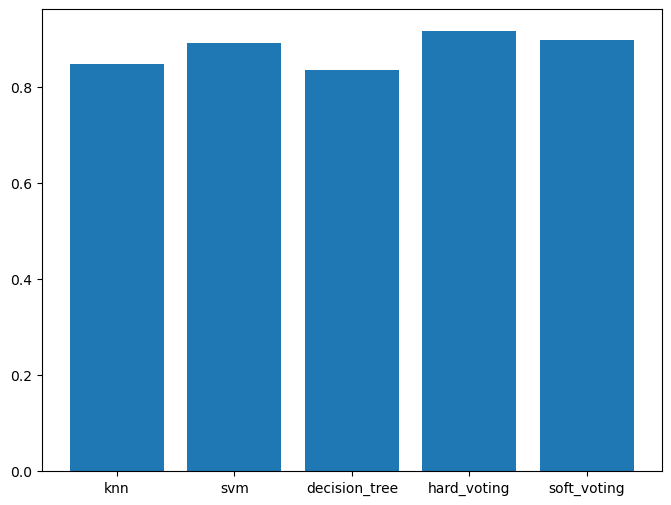

In [32]:
plt.figure(figsize=(8, 6))
x = np.arange(5)
plt.bar(x, height=[
    accuracy_score(y_test, knn_predict),
    accuracy_score(y_test, svm_predict),
    accuracy_score(y_test, dtree_predict),
    accuracy_score(y_test, hard_voting_predict),
    accuracy_score(y_test, soft_voting_predict)
])
plt.xticks(x, ['knn', 'svm', 'decision_tree', 'hard_voting', 'soft_voting'])
plt.show()